# Service Delivery Protest Risk for The Republic of South Africa  
**Hackathon Notebook**

**Purpose of this Notebook:** Indicates our journey of building a simple, transparent pipeline: data cleaning → EDA → features → model → evaluation → export artifacts for Streamlit deployment.

**Team NUST**
1. Gareth N.M Chiwara
2. Epafras Nehoya 
3. Stacy Muheua
4. Antony Schwartbooy
5. Max Haikali 
6. Ismael Mudjanima



## 1 Setup
#### 1.1 Imports & package check 

In [1]:
import sys
!{sys.executable} -m pip install -q --disable-pip-version-check openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

pd.set_option("display.max_columns", 0)
print("✅ Imports OK")


✅ Imports OK


### Project dirs

In [2]:
DATA_DIR = Path("data")
ARTIFACTS_DIR = Path("artifacts"); ARTIFACTS_DIR.mkdir(exist_ok=True)
assert DATA_DIR.exists(), "The 'data' folder was not found next to this notebook."

## 2) Data inventory & robust path resolution

#### 2.1 List files in /data

In [3]:

print("Files found in data/:")
for p in sorted(DATA_DIR.glob("*")):
    print(" -", p.name)


def find_file(part: str) -> Path:
    part = part.lower()
    matches = [p for p in DATA_DIR.glob("*") if part in p.name.lower()]
    if not matches:
        raise FileNotFoundError(f"No file contains: {part}")
    if len(matches) > 1:
        print("ℹ️ Multiple matches, using first:", [m.name for m in matches])
    return matches[0]

demo_path      = find_file("demonstration_events_by_month-year")
pol_viol_path  = find_file("political_violence_events_and_fatalities")
civ_targ_path  = find_file("civilian_targeting_events_and_fatalities")
crime_ann_path = find_file("annual_stats")
crime_q4_path  = find_file("q4_crime_stats")
census_path    = find_file("themes_24-10-2023")

demo_path, pol_viol_path, civ_targ_path, crime_ann_path, crime_q4_path, census_path


Files found in data/:
 - .ipynb_checkpoints
 - 2023-2024 _Annual_Stats.xlsx
 - 2024-2025_Q4_crime_stats.xlsx
 - additional - south-africa_civilian_targeting_events_and_fatalities_by_month-year_as-of-13aug2025.xlsx
 - additional - south-africa_political_violence_events_and_fatalities_by_month-year_as-of-13aug2025.xlsx
 - Census 2022_Themes_24-10-2023.xlsx
 - P03014_Census_2022_Statistical_Release.pdf
 - south-africa_demonstration_events_by_month-year_as-of-13aug2025.xlsx


(WindowsPath('data/south-africa_demonstration_events_by_month-year_as-of-13aug2025.xlsx'),
 WindowsPath('data/additional - south-africa_political_violence_events_and_fatalities_by_month-year_as-of-13aug2025.xlsx'),
 WindowsPath('data/additional - south-africa_civilian_targeting_events_and_fatalities_by_month-year_as-of-13aug2025.xlsx'),
 WindowsPath('data/2023-2024 _Annual_Stats.xlsx'),
 WindowsPath('data/2024-2025_Q4_crime_stats.xlsx'),
 WindowsPath('data/Census 2022_Themes_24-10-2023.xlsx'))

## 3) Loading the raw datasets

In [4]:
# Load
demo_df        = pd.read_excel(demo_path)        # ACLED demonstrations
political_df   = pd.read_excel(pol_viol_path)    # ACLED political violence
civilian_df    = pd.read_excel(civ_targ_path)    # ACLED civilian targeting
crime_annual_df = pd.read_excel(crime_ann_path)  # SAPS annual (full workbook)
crime_q4_df     = pd.read_excel(crime_q4_path)   # SAPS Q4 (full workbook)
census_df       = pd.read_excel(census_path)     # Stats SA Census 2022 Themes
print("✅ Loaded all dataframes.")

# Quick inspection
datasets = {
    "Demonstrations": demo_df,
    "Political Violence": political_df,
    "Civilian Targeting": civilian_df,
    "Crime Annual": crime_annual_df,
    "Crime Q4": crime_q4_df,
    "Census 2022": census_df
}
for name, df in datasets.items():
    print(f"\n=== {name} ===")
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    display(df.head(3))


✅ Loaded all dataframes.

=== Demonstrations ===
Shape: (8, 1)
Columns: ['Licensing']


,Licensing
0,By using ACLED data you agree to abide by the ...
1,https://acleddata.com/terms-of-use/
2,NaN



=== Political Violence ===
Shape: (8, 1)
Columns: ['Licensing']


,Licensing
0,By using ACLED data you agree to abide by the ...
1,https://acleddata.com/terms-of-use/
2,NaN



=== Civilian Targeting ===
Shape: (8, 1)
Columns: ['Licensing']


,Licensing
0,By using ACLED data you agree to abide by the ...
1,https://acleddata.com/terms-of-use/
2,NaN



=== Crime Annual ===
Shape: (1229, 34)
Columns: ['Select offence', 'Unnamed: 1', 'Unnamed: 2', 'Station', 'District', 'Province', 'Unnamed: 6', 'Unnamed: 7', 'District.1', 'Province.1', 'Unnamed: 10', 'Province.2', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'LISTS OF STATIONS PER', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 1, '01', 'January']


,Select offence,Unnamed: 1,Unnamed: 2,Station,District,Province,Unnamed: 6,Unnamed: 7,District.1,Province.1,Unnamed: 10,Province.2,Unnamed: 12,Unnamed: 13,Unnamed: 14,LISTS OF STATIONS PER,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,1,01,January
0,17 Community reported serious crime,NaN,NaN,Afsondering,Alfred Nzo District,Eastern Cape,Station,50,Alfred Nzo District,Eastern Cape,NaN,Eastern Cape,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,February
1,Abduction,NaN,NaN,Avondale,Alfred Nzo District,Eastern Cape,Station,50,Amathole District,Eastern Cape,NaN,Free State,NaN,Select Province,NaN,Eastern Cape,Free State,Gauteng,KwaZulu-Natal,Limpopo,Mpumalanga,North West,Northern Cape,Western Cape,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,March
2,All theft not mentioned elsewhere,NaN,NaN,Cedarville,Alfred Nzo District,Eastern Cape,Station,50,Buffalo City District,Eastern Cape,NaN,Gauteng,NaN,Aberdeen,NaN,Aberdeen,Allanridge,Actonville,Alexandra Road,Alldays,Acornhoek,Amalia,Aggeneys,Albertinia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,April



=== Crime Q4 ===
Shape: (1246, 54)
Columns: ['Select offence', 'Unnamed: 1', 'Unnamed: 2', 'Station', 'District', 'Province', 'Unnamed: 6', 'Unnamed: 7', 'District.1', 'Province.1', 'Unnamed: 10', 'Province.2', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'LISTS OF STATIONS PER', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 1, '01', 'January', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Population figures', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52', 'Unnamed: 53']


,Select offence,Unnamed: 1,Unnamed: 2,Station,District,Province,Unnamed: 6,Unnamed: 7,District.1,Province.1,Unnamed: 10,Province.2,Unnamed: 12,Unnamed: 13,Unnamed: 14,LISTS OF STATIONS PER,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,1,01,January,Unnamed: 34,Unnamed: 35,Unnamed: 36,Population figures,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53
0,17 Community reported serious Crime,NaN,NaN,Afsondering,Alfred Nzo District,Eastern Cape,Station,50.0,Alfred Nzo District,Eastern Cape,NaN,Eastern Cape,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,February,NaN,NaN,NaN,NaN,NaN,2021.0,2022.0,2023.0,2024.0,2025.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Afsondering,Station
1,Abduction,NaN,NaN,Avondale,Alfred Nzo District,Eastern Cape,Station,50.0,Amathole District,Eastern Cape,NaN,Free State,NaN,Select Province,NaN,Eastern Cape,Free State,Gauteng,KwaZulu-Natal,Limpopo,Mpumalanga,North West,Northern Cape,Western Cape,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,March,NaN,NaN,Eastern Cape,Eastern Cape,Mid Nov,6683354.0,6667624.0,6655610.0,6643991.0,6631264.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Avondale,Station
2,All theft not mentioned elsewhere,NaN,NaN,Cedarville,Alfred Nzo District,Eastern Cape,Station,50.0,Buffalo City District,Eastern Cape,NaN,Gauteng,NaN,Select component,NaN,Select component,Select component,Select component,Select component,Select component,Select component,Select component,Select component,Select component,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,April,NaN,NaN,Free State,Free State,Mid Nov,2930556.0,2938535.0,2949152.0,2959911.0,2970394.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cedarville,Station



=== Census 2022 ===
Shape: (267, 10)
Columns: ['Province name', 'Province abbreviation', 'Province  code', 'District municipality code', 'District municipality name', 'Metro/Local municipality code', 'District/Local municipality name', 'Local municipality code', 'ID', 'N']


,Province name,Province abbreviation,Province code,District municipality code,District municipality name,Metro/Local municipality code,District/Local municipality name,Local municipality code,ID,N
0,NaN,NaN,NaN,NaN,NaN,SA,SA,NaN,NaN,6.202750e+07
1,Western Cape,WC,1.0,NaN,NaN,1,Western Cape,NaN,NaN,7.433020e+06
2,Western Cape,WC,1.0,NaN,NaN,CPT,City of Cape Town,199.0,3.0,4.772846e+06


## 4) Cleaning SAPS (Annual & Q4)



#### 4.1 Probe headers

In [5]:
def probe_headers(path, sheet="RAW Data", max_hdr=4):
    for hdr in range(max_hdr+1):
        try:
            tmp = pd.read_excel(path, sheet_name=sheet, header=hdr, nrows=3)
            print(f"\n{path.name} | header={hdr} → first 12 cols:")
            print(list(tmp.columns)[:12])
        except Exception as e:
            print(f"header={hdr} error: {e}")

print("ANNUAL:"); probe_headers(crime_ann_path, sheet="RAW Data")
print("\nQ4:");   probe_headers(crime_q4_path,  sheet="RAW Data")


ANNUAL:

2023-2024 _Annual_Stats.xlsx | header=0 → first 12 cols:
['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'April to March 2013-2014 to 2022-2023', 'Unnamed: 8', 7, 8, 9]

2023-2024 _Annual_Stats.xlsx | header=1 → first 12 cols:
['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'April to March 2021-2022 vs 2022-2023', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11']

2023-2024 _Annual_Stats.xlsx | header=2 → first 12 cols:
['Crime_Category National contribution\nplacement', 'Crime_Category Provincial contribution\nplacement', 'Comp level', 'Station Crime_Category', 'Station', 'District', 'Province', 'Crime_Category', 'Code', '2013-2014', '2014-2015', '2015-2016']

2023-2024 _Annual_Stats.xlsx | header=3 → first 12 cols:
['Murder Station 524', 'Eastern Cape Murder Station 98', 'Station', 'Afsondering Murder', 'Afsondering', 'Alfred Nzo District', 'Eastern Cape', 'Murder', 

## quick inspection 

In [6]:

datasets = {
    "Demonstrations": demo_df,
    "Political Violence": political_df,
    "Civilian Targeting": civilian_df,
    "Crime Annual": crime_annual_df,
    "Crime Q4": crime_q4_df,
    "Census 2022": census_df
}

for name, df in datasets.items():
    print(f"\n=== {name} ===")
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    display(df.head(3))



=== Demonstrations ===
Shape: (8, 1)
Columns: ['Licensing']


,Licensing
0,By using ACLED data you agree to abide by the ...
1,https://acleddata.com/terms-of-use/
2,NaN



=== Political Violence ===
Shape: (8, 1)
Columns: ['Licensing']


,Licensing
0,By using ACLED data you agree to abide by the ...
1,https://acleddata.com/terms-of-use/
2,NaN



=== Civilian Targeting ===
Shape: (8, 1)
Columns: ['Licensing']


,Licensing
0,By using ACLED data you agree to abide by the ...
1,https://acleddata.com/terms-of-use/
2,NaN



=== Crime Annual ===
Shape: (1229, 34)
Columns: ['Select offence', 'Unnamed: 1', 'Unnamed: 2', 'Station', 'District', 'Province', 'Unnamed: 6', 'Unnamed: 7', 'District.1', 'Province.1', 'Unnamed: 10', 'Province.2', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'LISTS OF STATIONS PER', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 1, '01', 'January']


,Select offence,Unnamed: 1,Unnamed: 2,Station,District,Province,Unnamed: 6,Unnamed: 7,District.1,Province.1,Unnamed: 10,Province.2,Unnamed: 12,Unnamed: 13,Unnamed: 14,LISTS OF STATIONS PER,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,1,01,January
0,17 Community reported serious crime,NaN,NaN,Afsondering,Alfred Nzo District,Eastern Cape,Station,50,Alfred Nzo District,Eastern Cape,NaN,Eastern Cape,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,February
1,Abduction,NaN,NaN,Avondale,Alfred Nzo District,Eastern Cape,Station,50,Amathole District,Eastern Cape,NaN,Free State,NaN,Select Province,NaN,Eastern Cape,Free State,Gauteng,KwaZulu-Natal,Limpopo,Mpumalanga,North West,Northern Cape,Western Cape,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,March
2,All theft not mentioned elsewhere,NaN,NaN,Cedarville,Alfred Nzo District,Eastern Cape,Station,50,Buffalo City District,Eastern Cape,NaN,Gauteng,NaN,Aberdeen,NaN,Aberdeen,Allanridge,Actonville,Alexandra Road,Alldays,Acornhoek,Amalia,Aggeneys,Albertinia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,April



=== Crime Q4 ===
Shape: (1246, 54)
Columns: ['Select offence', 'Unnamed: 1', 'Unnamed: 2', 'Station', 'District', 'Province', 'Unnamed: 6', 'Unnamed: 7', 'District.1', 'Province.1', 'Unnamed: 10', 'Province.2', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'LISTS OF STATIONS PER', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 1, '01', 'January', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Population figures', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52', 'Unnamed: 53']


,Select offence,Unnamed: 1,Unnamed: 2,Station,District,Province,Unnamed: 6,Unnamed: 7,District.1,Province.1,Unnamed: 10,Province.2,Unnamed: 12,Unnamed: 13,Unnamed: 14,LISTS OF STATIONS PER,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,1,01,January,Unnamed: 34,Unnamed: 35,Unnamed: 36,Population figures,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53
0,17 Community reported serious Crime,NaN,NaN,Afsondering,Alfred Nzo District,Eastern Cape,Station,50.0,Alfred Nzo District,Eastern Cape,NaN,Eastern Cape,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,February,NaN,NaN,NaN,NaN,NaN,2021.0,2022.0,2023.0,2024.0,2025.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Afsondering,Station
1,Abduction,NaN,NaN,Avondale,Alfred Nzo District,Eastern Cape,Station,50.0,Amathole District,Eastern Cape,NaN,Free State,NaN,Select Province,NaN,Eastern Cape,Free State,Gauteng,KwaZulu-Natal,Limpopo,Mpumalanga,North West,Northern Cape,Western Cape,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,March,NaN,NaN,Eastern Cape,Eastern Cape,Mid Nov,6683354.0,6667624.0,6655610.0,6643991.0,6631264.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Avondale,Station
2,All theft not mentioned elsewhere,NaN,NaN,Cedarville,Alfred Nzo District,Eastern Cape,Station,50.0,Buffalo City District,Eastern Cape,NaN,Gauteng,NaN,Select component,NaN,Select component,Select component,Select component,Select component,Select component,Select component,Select component,Select component,Select component,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,April,NaN,NaN,Free State,Free State,Mid Nov,2930556.0,2938535.0,2949152.0,2959911.0,2970394.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cedarville,Station



=== Census 2022 ===
Shape: (267, 10)
Columns: ['Province name', 'Province abbreviation', 'Province  code', 'District municipality code', 'District municipality name', 'Metro/Local municipality code', 'District/Local municipality name', 'Local municipality code', 'ID', 'N']


,Province name,Province abbreviation,Province code,District municipality code,District municipality name,Metro/Local municipality code,District/Local municipality name,Local municipality code,ID,N
0,NaN,NaN,NaN,NaN,NaN,SA,SA,NaN,NaN,6.202750e+07
1,Western Cape,WC,1.0,NaN,NaN,1,Western Cape,NaN,NaN,7.433020e+06
2,Western Cape,WC,1.0,NaN,NaN,CPT,City of Cape Town,199.0,3.0,4.772846e+06


#### 4.2 Define cleaners
- Cell B

In [7]:
import re
import pandas as pd

def clean_crime_annual(path, sheet="RAW Data", header=2):
    df = pd.read_excel(path, sheet_name=sheet, header=header)
    df.columns = [str(c).strip().replace("\n", " ") for c in df.columns]
    prov_col = next((c for c in df.columns if "province" in c.lower()), None)
    cat_col  = next((c for c in df.columns if "crime category" in c.lower() or c.lower().startswith("crime")), None)
    keep = [c for c in [prov_col, cat_col] if c]

    year_cols = [c for c in df.columns if isinstance(c, str) and re.fullmatch(r"\d{4}\s*-\s*\d{4}", c)]
    if not year_cols:
        year_cols = [c for c in df.columns if isinstance(c, str) and re.fullmatch(r"\d{4}", c)]
    use = df[keep + year_cols].copy()
    if prov_col: use = use[use[prov_col].notna()]
    if cat_col:  use = use[use[cat_col].notna()]

    long_df = use.melt(id_vars=keep, value_vars=year_cols, var_name="year_key", value_name="count")
    long_df["year"] = long_df["year_key"].str.extract(r"(?:\d{4}\s*-\s*)(\d{4})|(\d{4})").ffill(axis=1).iloc[:,0].astype(int)

    if prov_col and prov_col != "province":      long_df = long_df.rename(columns={prov_col: "province"})
    if cat_col and cat_col != "crime_category":  long_df = long_df.rename(columns={cat_col: "crime_category"})
    long_df["count"] = pd.to_numeric(long_df["count"], errors="coerce")
    long_df = long_df.dropna(subset=["count"])
    long_df = long_df.groupby(["province","crime_category","year"], as_index=False)["count"].sum()
    long_df = long_df[~long_df["province"].str.contains(r"RSA|National", case=False, na=False)]
    return long_df.sort_values(["province","crime_category","year"]).reset_index(drop=True)

def clean_crime_q4(path, sheet="RAW Data", header=2):
    df = pd.read_excel(path, sheet_name=sheet, header=header)
    df.columns = [str(c).strip().replace("\n", " ") for c in df.columns]
    prov_col = next((c for c in df.columns if "province" in c.lower()), None)
    cat_col  = next((c for c in df.columns if "crime category" in c.lower() or c.lower().startswith("crime")), None)
    keep = [c for c in [prov_col, cat_col] if c]

    summary_cols = [c for c in df.columns if isinstance(c, str) and "January" in c and "March" in c]
    if summary_cols:
        long_df = df[keep + summary_cols].melt(id_vars=keep, value_vars=summary_cols,
                                               var_name="period", value_name="count")
        long_df["year"] = long_df["period"].str.extract(r"March\s+(\d{4})").astype(int)
    else:
        ts_cols = [c for c in df.columns if isinstance(c, pd.Timestamp)]
        wide = df[keep].copy()
        years = sorted({c.year for c in ts_cols})
        for y in years:
            jan_feb_mar = [c for c in ts_cols if c.year == y and c.month in (1,2,3)]
            if jan_feb_mar:
                wide[str(y)] = df[jan_feb_mar].sum(axis=1)
        value_cols = [c for c in wide.columns if re.fullmatch(r"\d{4}", str(c))]
        long_df = wide.melt(id_vars=keep, value_vars=value_cols, var_name="year", value_name="count")
        long_df["year"] = long_df["year"].astype(int)

    if prov_col and prov_col != "province":      long_df = long_df.rename(columns={prov_col: "province"})
    if cat_col and cat_col != "crime_category":  long_df = long_df.rename(columns={cat_col: "crime_category"})
    long_df["count"] = pd.to_numeric(long_df["count"], errors="coerce")
    long_df = long_df.dropna(subset=["count"])
    long_df = long_df.groupby(["province","crime_category","year"], as_index=False)["count"].sum()
    long_df = long_df[~long_df["province"].str.contains(r"RSA|National", case=False, na=False)]
    return long_df.sort_values(["province","crime_category","year"]).reset_index(drop=True)


#### 4.3 Run, check, save

In [8]:

crime_annual_clean = clean_crime_annual(crime_ann_path, sheet="RAW Data", header=2)
crime_q4_clean     = clean_crime_q4(crime_q4_path,  sheet="RAW Data", header=2)

print("Annual shape:", crime_annual_clean.shape)
print("Q4 shape:", crime_q4_clean.shape)
display(crime_annual_clean.head(5)); display(crime_q4_clean.head(5))


print("Annual provinces:", sorted(crime_annual_clean["province"].unique())[:10])
print("Q4 provinces:",     sorted(crime_q4_clean["province"].unique())[:10])


crime_annual_clean.to_csv("crime_annual_clean.csv", index=False)
crime_q4_clean.to_csv("crime_q4_clean.csv", index=False)

common_cols = [c for c in crime_annual_clean.columns if c in crime_q4_clean.columns]
crime_all = pd.concat([crime_annual_clean[common_cols], crime_q4_clean[common_cols]], ignore_index=True)
crime_all.to_csv("crime_all_clean.csv", index=False)
print("✅ Saved: crime_annual_clean.csv, crime_q4_clean.csv, crime_all_clean.csv")


Annual shape: (474240, 4)
Q4 shape: (269940, 4)


,province,crime_category,year,count
0,Eastern Cape,17 Community reported serious crime Station 1000,2014,100.0
1,Eastern Cape,17 Community reported serious crime Station 1000,2015,126.0
2,Eastern Cape,17 Community reported serious crime Station 1000,2016,130.0
3,Eastern Cape,17 Community reported serious crime Station 1000,2017,129.0
4,Eastern Cape,17 Community reported serious crime Station 1000,2018,130.0


,province,crime_category,year,count
0,Eastern Cape,17 Community reported serious Crime Station 1000,2021,46.0
1,Eastern Cape,17 Community reported serious Crime Station 1000,2022,43.0
2,Eastern Cape,17 Community reported serious Crime Station 1000,2023,29.0
3,Eastern Cape,17 Community reported serious Crime Station 1000,2024,47.0
4,Eastern Cape,17 Community reported serious Crime Station 1000,2025,33.0


Annual provinces: ['Eastern Cape', 'Free State', 'Gauteng', 'KwaZulu-Natal', 'Limpopo', 'Mpumalanga', 'North West', 'Northern Cape', 'Republic of South Africa', 'Western Cape']
Q4 provinces: ['Eastern Cape', 'Free State', 'Gauteng', 'KwaZulu-Natal', 'Limpopo', 'Mpumalanga', 'North West', 'Northern Cape', 'Republic of South Africa', 'Western Cape']
✅ Saved: crime_annual_clean.csv, crime_q4_clean.csv, crime_all_clean.csv


#### 5) Data health check (on merged)


In [9]:
crime = pd.read_csv("crime_all_clean.csv")
print("Shape of dataset:", crime.shape)
print("\n--- Info ---"); print(crime.info())
print("\n--- Nulls ---"); print(crime.isnull().sum())
print("\n--- Duplicates ---"); print("Duplicate rows:", crime.duplicated().sum())
print("\n--- Summary ---"); print(crime.describe())


Shape of dataset: (744180, 4)

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744180 entries, 0 to 744179
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   province        744180 non-null  object 
 1   crime_category  744180 non-null  object 
 2   year            744180 non-null  int64  
 3   count           744180 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 22.7+ MB
None

--- Nulls ---
province          0
crime_category    0
year              0
count             0
dtype: int64

--- Duplicates ---
Duplicate rows: 3528

--- Summary ---
                year          count
count  744180.000000  744180.000000
mean     2020.132307     172.320504
std         3.265559    1741.224977
min      2014.000000      -1.000000
25%      2017.000000       0.000000
50%      2021.000000       8.000000
75%      2023.000000      54.000000
max      2025.000000  255613.000000


#### 6) EDA (storytelling visuals)


In [10]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

sns.set_theme(style="whitegrid", context="talk")

def kfmt(x, _):
    if x >= 1_000_000: return f"{x/1_000_000:.1f}M"
    if x >= 1_000:     return f"{x/1_000:.1f}k"
    return f"{int(x)}"

#### 6.2 Heatmap: Crimes by Province × Year
- spoting persistent hotspots and shifts across years

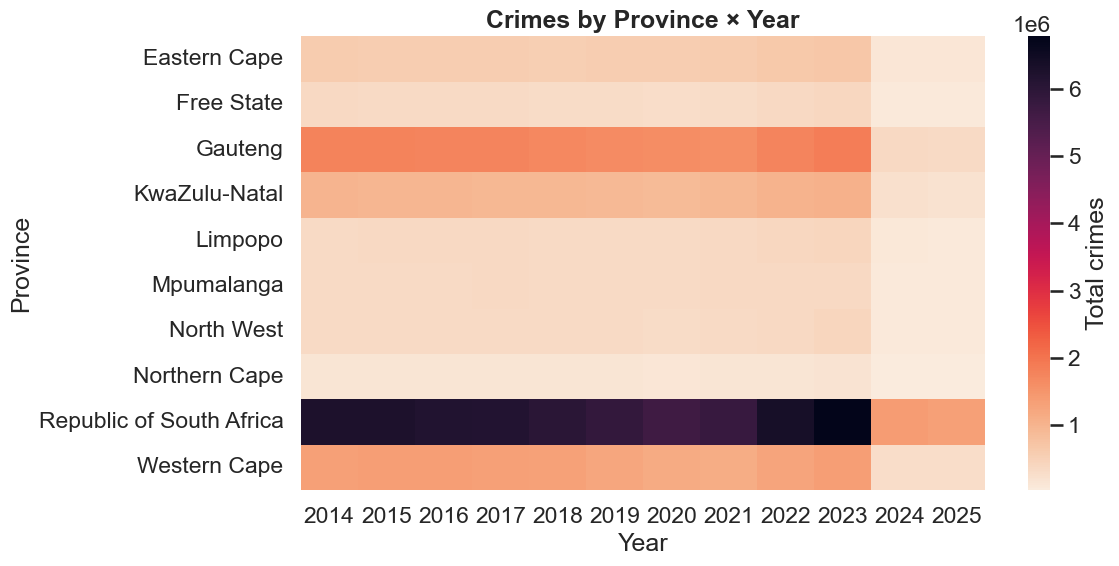

In [11]:
plt.figure(figsize=(12,6))
heatmap_data = crime.pivot_table(values="count", index="province", columns="year", aggfunc="sum").fillna(0)
sns.heatmap(heatmap_data, cmap="rocket_r", cbar_kws={'label': 'Total crimes'})
plt.title("Crimes by Province × Year", weight="bold")
plt.xlabel("Year"); plt.ylabel("Province")
plt.tight_layout(); plt.show()


**Insight:** The heatmap highlights persistent hotspots and shifts across provinces.  
Redder cells show higher reported crimes, helping identify where crime is most concentrated year-to-year.


#### 6.3 Top-5 Crime Categories on a national scale

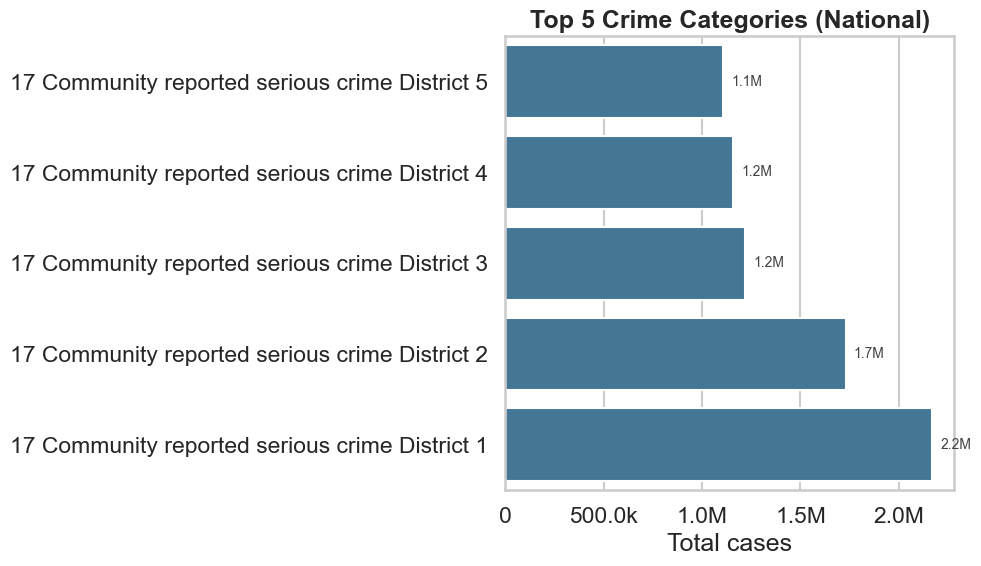

In [12]:
top5 = crime.groupby("crime_category")["count"].sum().nlargest(5).sort_values()
top5_df = top5.to_frame("count").reset_index()

plt.figure(figsize=(10,6))

color = sns.color_palette("mako", 3)[1]
ax = sns.barplot(data=top5_df, x="count", y="crime_category", color=color)
ax.xaxis.set_major_formatter(FuncFormatter(kfmt))
plt.title("Top 5 Crime Categories (National)", weight="bold")
plt.xlabel("Total cases"); plt.ylabel("")

for p in ax.patches:
    v = p.get_width()
    ax.annotate(f"{kfmt(v,None)}", (p.get_x()+v, p.get_y()+p.get_height()/2),
                xytext=(6,0), textcoords="offset points", va="center", fontsize=10, color="#444")
plt.tight_layout(); plt.show()


**Insight:** These five categories dominate South Africa’s crime landscape.  
They account for the majority of cases, making them critical focus areas for policing and policy.


#### 6.4 Province Comparison showing only the Top-5 categories

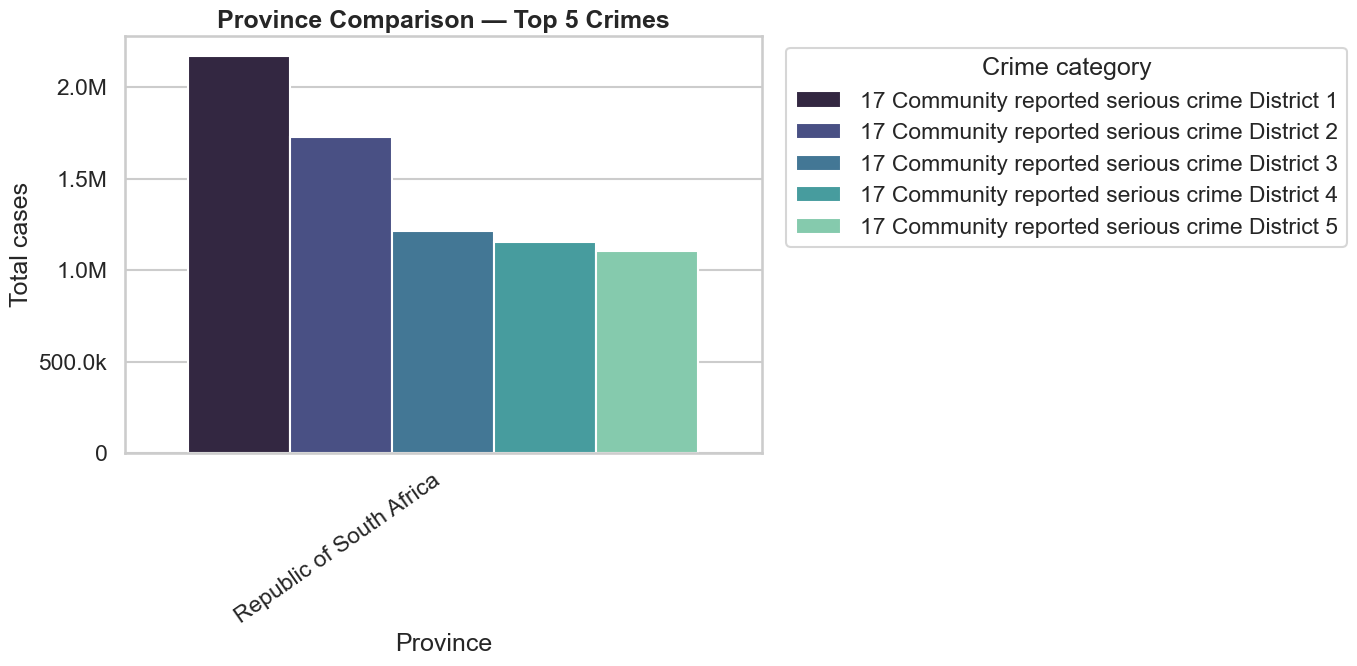

In [13]:
province_cat = crime.groupby(["province","crime_category"])["count"].sum().reset_index()
subset = province_cat[province_cat["crime_category"].isin(top5.index)]

plt.figure(figsize=(14,7))
ax = sns.barplot(data=subset, x="province", y="count", hue="crime_category", palette="mako")
ax.yaxis.set_major_formatter(FuncFormatter(kfmt))
plt.title("Province Comparison — Top 5 Crimes", weight="bold")
plt.xlabel("Province"); plt.ylabel("Total cases")
plt.xticks(rotation=35, ha="right")   # rotate labels; 'ha' goes in plt.xticks, not set_tick_params
plt.legend(title="Crime category", bbox_to_anchor=(1.02,1), loc="upper left", frameon=True)
plt.tight_layout(); plt.show()


**Insight:** Provinces face different mixes of top crimes.  
For example, one province may be dominated by assault, while another has higher robbery cases.  
This emphasizes the need for province-specific strategies.


#### 6.5 National Trend Over Time

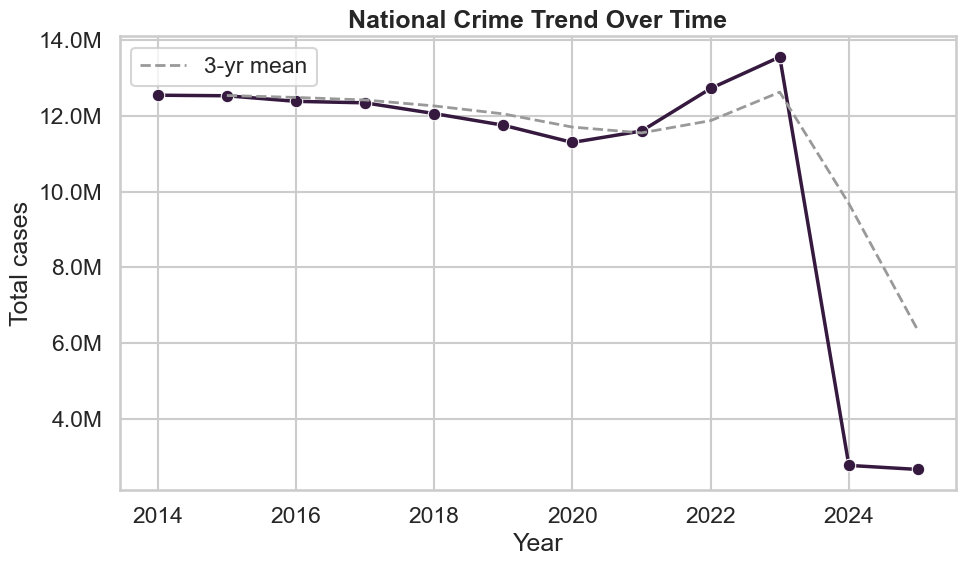

In [14]:
trend = crime.groupby("year")["count"].sum().sort_index()

plt.figure(figsize=(10,6))
ax = sns.lineplot(x=trend.index, y=trend.values, marker="o", linewidth=2.5, color=sns.color_palette("rocket")[0])
ax.yaxis.set_major_formatter(FuncFormatter(kfmt))
plt.title("National Crime Trend Over Time", weight="bold")
plt.xlabel("Year"); plt.ylabel("Total cases")


if len(trend) >= 3:
    rm = trend.rolling(3, min_periods=2).mean()
    sns.lineplot(x=rm.index, y=rm.values, linewidth=2, linestyle="--", color="#999", label="3-yr mean")
    plt.legend(frameon=True)

plt.tight_layout(); plt.show()


**Insight:** The trend shows how crime has evolved nationally. 
Sharp rises or dips often align with major socio-economic or policy events.


#### 6.6 Gauteng close look
- We decided to use gauteng in terms of data visual of a specific province

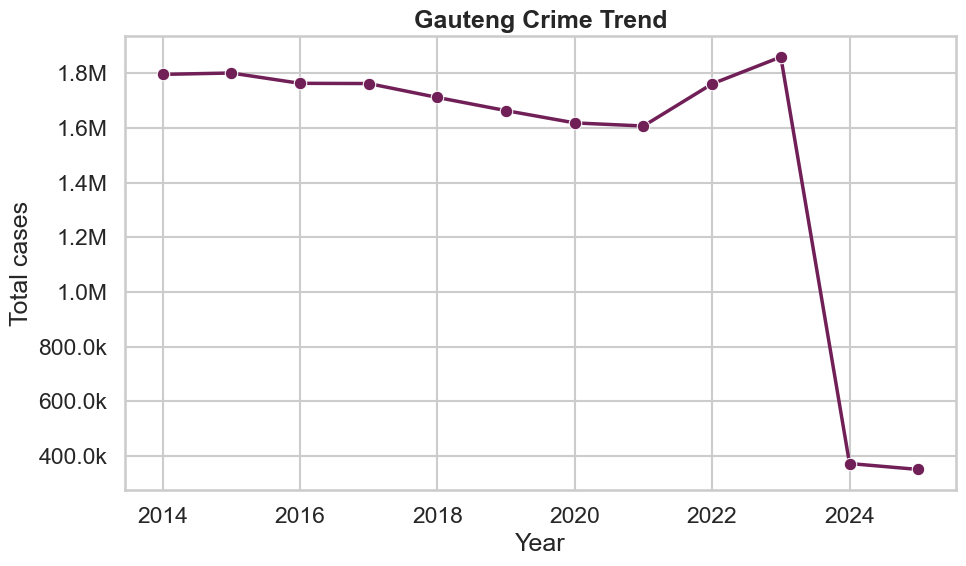

In [15]:
gauteng = (crime[crime["province"].str.lower()=="gauteng"]
           .groupby("year")["count"].sum().reset_index())

plt.figure(figsize=(10,6))
ax = sns.lineplot(data=gauteng, x="year", y="count", marker="o", linewidth=2.5, color=sns.color_palette("rocket")[1])
ax.yaxis.set_major_formatter(FuncFormatter(kfmt))
plt.title("Gauteng Crime Trend", weight="bold")
plt.xlabel("Year"); plt.ylabel("Total cases")
plt.tight_layout(); plt.show()


**Insight:** Gauteng, as the country’s economic hub, shows distinct crime dynamics.  
Tracking its trend separately shows whether national patterns are being driven by Gauteng or other provinces.


#### 6.7 Regression scatter

In [16]:
if "features" in globals() and {"roll3_mean","count"}.issubset(features.columns):
    
    f_agg = (features.groupby(["province","year"])[["count","roll3_mean"]]
                    .sum()
                    .reset_index())
    plt.figure(figsize=(8,6))
    sns.regplot(data=f_agg, x="roll3_mean", y="count",
                scatter_kws=dict(alpha=0.25, s=30), line_kws=dict(color="red", linewidth=2))
    plt.gca().xaxis.set_major_formatter(FuncFormatter(kfmt))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(kfmt))
    plt.title("Predictive Signal: 3-yr Mean vs Current Count", weight="bold")
    plt.xlabel("3-year rolling mean (sum)"); plt.ylabel("Current year total (sum)")
    plt.tight_layout(); plt.show()
else:
    print("ℹ️ Skipping regression scatter — `features` with `roll3_mean` not found.")


ℹ️ Skipping regression scatter — `features` with `roll3_mean` not found.


**Insight:** The scatter with regression line shows that recent history (3-year rolling mean) strongly predicts current year totals.  
This validates the idea that past crime patterns carry a signal useful for forecasting and prevention strategies.


#### == EDA Dashboard ===

✅ Saved dashboard → artifacts/eda_dashboard.png


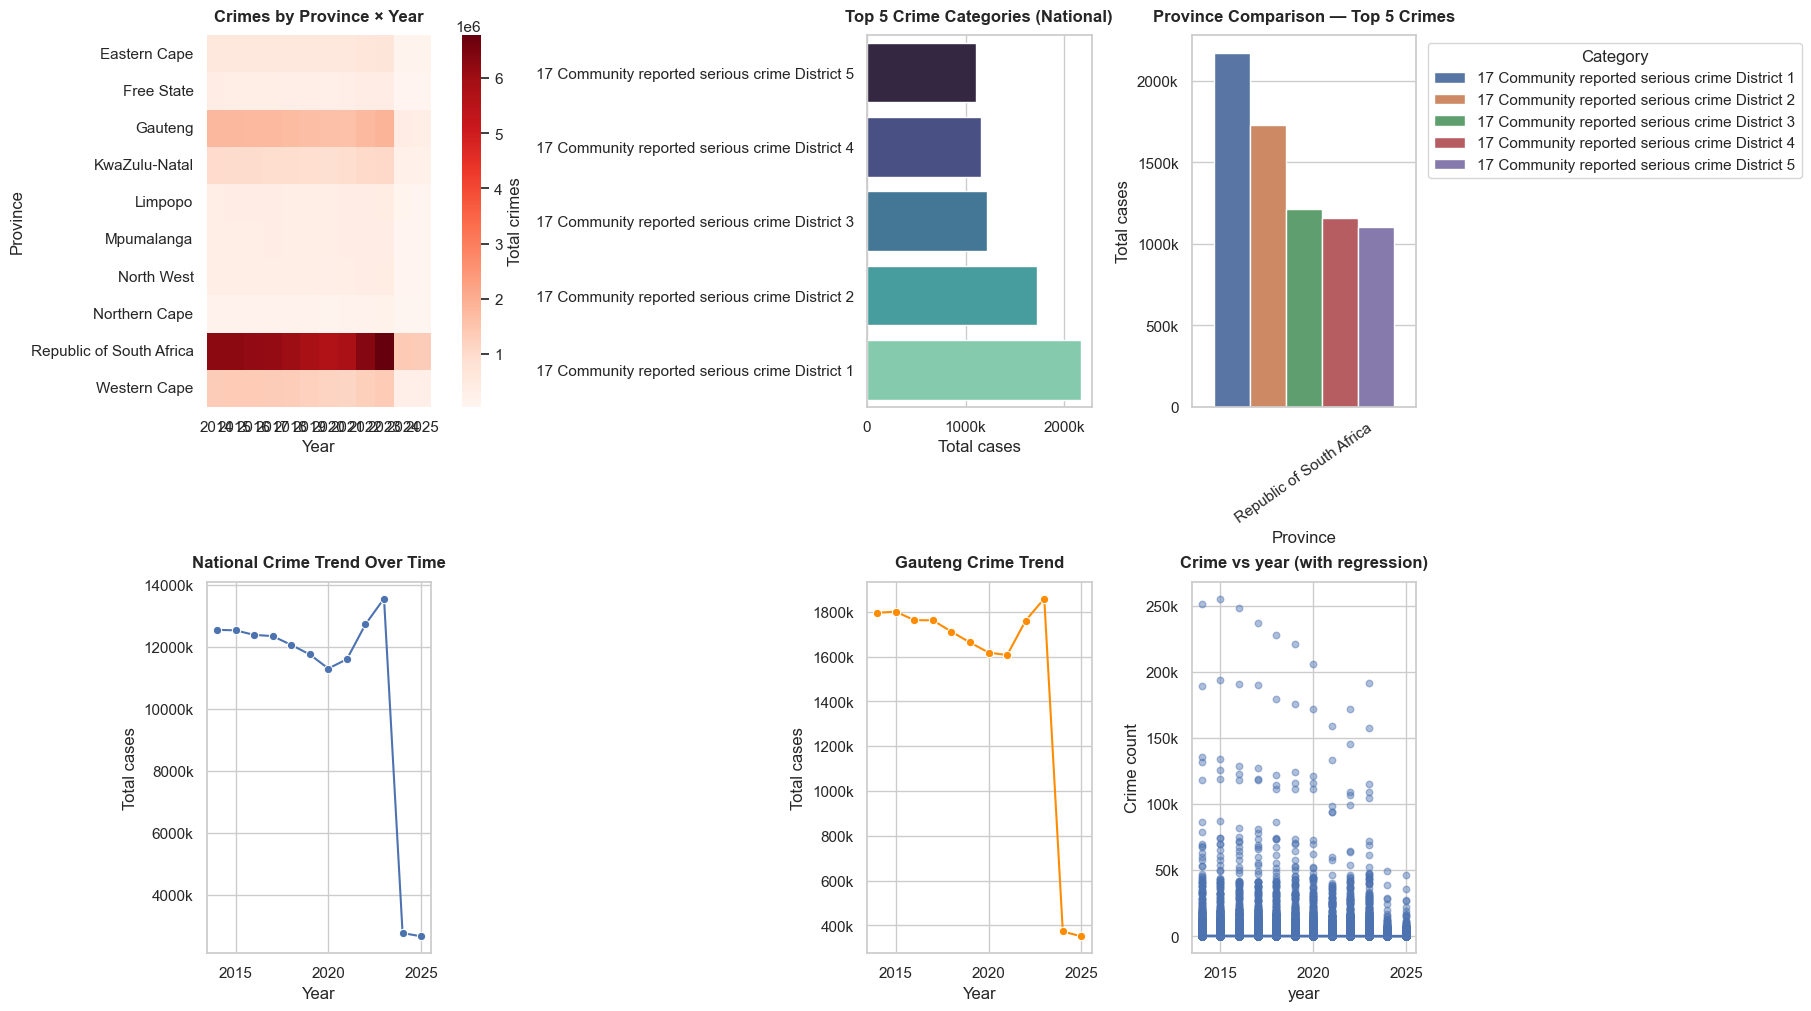

In [17]:

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

sns.set_theme(style="whitegrid")

def kfmt(x, pos):
    return f"{int(x/1_000)}k" if x >= 1_000 else f"{int(x)}"


heatmap_data = crime.pivot_table(values="count", index="province", columns="year", aggfunc="sum")

top5 = (crime.groupby("crime_category")["count"]
              .sum()
              .nlargest(5)
              .sort_values(ascending=True))                       
top5_df = top5.reset_index().rename(columns={"crime_category":"category","count":"count"})

province_cat = crime.groupby(["province","crime_category"])["count"].sum().reset_index()
subset = province_cat[province_cat["crime_category"].isin(top5.index)]
trend = crime.groupby("year")["count"].sum().reset_index()

gauteng = crime[crime["province"].str.lower()=="gauteng"]
gauteng_trend = gauteng.groupby("year")["count"].sum().reset_index()


if "roll3_mean" in crime.columns:
    reg_x = "roll3_mean"; reg_label = "3-yr rolling mean"
else:
    reg_x = "year";       reg_label = "year"
reg_data = crime[[reg_x, "count"]].dropna()


fig, axes = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)
(ax_hm, ax_top5, ax_group,
 ax_nat, ax_gtg, ax_reg) = axes.ravel()


hm = sns.heatmap(
    heatmap_data,
    cmap="Reds",
    cbar_kws={"label":"Total crimes"},
    ax=ax_hm
)
ax_hm.set_title("Crimes by Province × Year", pad=10)
ax_hm.set_xlabel("Year"); ax_hm.set_ylabel("Province")


sns.barplot(
    data=top5_df, x="count", y="category",
    hue="category", legend=False, palette="mako", ax=ax_top5
)
ax_top5.set_title("Top 5 Crime Categories (National)", pad=10)
ax_top5.set_xlabel("Total cases"); ax_top5.set_ylabel("")
ax_top5.xaxis.set_major_formatter(FuncFormatter(kfmt))


sns.barplot(
    data=subset, x="province", y="count",
    hue="crime_category", ax=ax_group
)
ax_group.set_title("Province Comparison — Top 5 Crimes", pad=10)
ax_group.set_xlabel("Province"); ax_group.set_ylabel("Total cases")
ax_group.xaxis.set_tick_params(rotation=35)
ax_group.yaxis.set_major_formatter(FuncFormatter(kfmt))
ax_group.legend(title="Category", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=True)


sns.lineplot(data=trend, x="year", y="count", marker="o", ax=ax_nat)
ax_nat.set_title("National Crime Trend Over Time", pad=10)
ax_nat.set_xlabel("Year"); ax_nat.set_ylabel("Total cases")
ax_nat.yaxis.set_major_formatter(FuncFormatter(kfmt))


sns.lineplot(data=gauteng_trend, x="year", y="count", marker="o", ax=ax_gtg, color="#FF8C00")
ax_gtg.set_title("Gauteng Crime Trend", pad=10)
ax_gtg.set_xlabel("Year"); ax_gtg.set_ylabel("Total cases")
ax_gtg.yaxis.set_major_formatter(FuncFormatter(kfmt))


sns.regplot(
    data=reg_data, x=reg_x, y="count",
    scatter_kws={"alpha":0.45, "s":22}, line_kws={"lw":2},
    ax=ax_reg
)
ax_reg.set_title(f"Crime vs {reg_label} (with regression)", pad=10)
ax_reg.set_xlabel(reg_label); ax_reg.set_ylabel("Crime count")
ax_reg.yaxis.set_major_formatter(FuncFormatter(kfmt))


for ax in (ax_hm, ax_top5, ax_group, ax_nat, ax_gtg, ax_reg):
    ax.title.set_fontweight("bold")


import os
os.makedirs("artifacts", exist_ok=True)
outpath = "artifacts/eda_dashboard.png"
plt.savefig(outpath, dpi=150, bbox_inches="tight")
print(f"✅ Saved dashboard → {outpath}")

plt.show()


## 7) Feature engineering section
- Per-capita rates this works with the census data we have as one of our datasets,
- the features are
   -YoY change, and 3-year rolling mean.


In [18]:

features = crime.copy()


features = features.sort_values(["province","crime_category","year"])
features["yoy_delta"] = features.groupby(["province","crime_category"])["count"].diff()


features["roll3_mean"] = features.groupby(["province","crime_category"])["count"].transform(
    lambda s: s.rolling(3, min_periods=2).mean()
)

features.to_csv(ARTIFACTS_DIR/"features_crime.csv", index=False)
print("✅ Saved engineered features →", ARTIFACTS_DIR/"features_crime.csv")


✅ Saved engineered features → artifacts\features_crime.csv


## 8) Our first minimal model
- Our goal was to try and predict protest over a period of a year

#### Regression: Next-Year Count (Model 1)

#### Our Baseline regression has proper preprocessing, one-hot enconding and scaling scaling

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


fe = features.copy()


for col in ["yoy_delta", "roll3_mean"]:
    if col in fe.columns:
        fe[col] = fe[col].fillna(0)

cat_cols = ["province", "crime_category"]
num_cols = [c for c in ["year", "yoy_delta", "roll3_mean"] if c in fe.columns]
X = fe[cat_cols + num_cols]
y = fe["count"]


preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(with_mean=False), num_cols),
    ]
)

# Our Model pipeline
pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LinearRegression())
])

# Our Train/test split and fit
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipe.fit(X_train, y_train)

# Our Evaluation matrics for this model
y_pred = pipe.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"✅ Baseline Linear Regression — MSE: {mse:,.2f} | R²: {r2:.3f}")


✅ Baseline Linear Regression — MSE: 129,914.06 | R²: 0.961


### Feature importance

#### feature coloumns and targets

In [20]:
import numpy as np

features["high_risk"] = (features["count"] > features["count"].median()).astype(int)

cat_cols = ["province", "crime_category"]
num_cols = [c for c in ["year", "yoy_delta", "roll3_mean"] if c in features.columns]

X = features[cat_cols + num_cols]
y = features["high_risk"]


In [21]:
import os, joblib
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

if os.path.exists("models/protest_risk_rf.pkl"):
    clf_pipe = joblib.load("models/protest_risk_rf.pkl")
    print("Loaded saved model: models/protest_risk_rf.pkl")
else:
    # compacting our model for fast training capabilities
    cat_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])
    num_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler(with_mean=False))
    ])
    preprocess = ColumnTransformer([
        ("cat", cat_pipe, cat_cols),
        ("num", num_pipe, num_cols),
    ])
    clf_pipe = Pipeline([
        ("prep", preprocess),
        ("model", RandomForestClassifier(
            n_estimators=100, max_depth=12, min_samples_leaf=5,
            class_weight="balanced_subsample", random_state=42, n_jobs=-1
        ))
    ])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    clf_pipe.fit(X_train, y_train)
    print("Trained a fresh RandomForest pipeline.")


Loaded saved model: models/protest_risk_rf.pkl


#### feature importance plot

C:\Users\maxnd\AppData\Local\Temp\ipykernel_26564\1806563239.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top, x="importance", y="feature", palette="viridis", edgecolor="black")


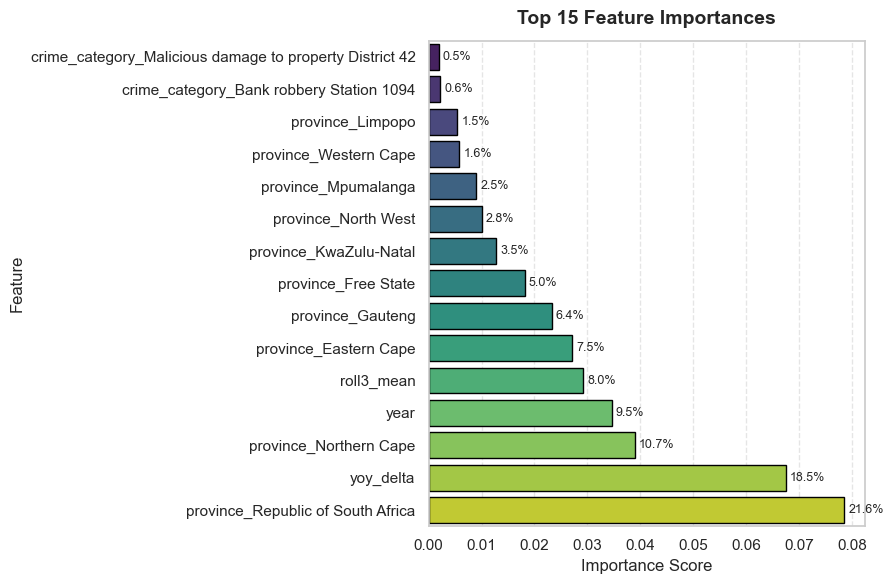

In [22]:


import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns


pipe = None
for name in ["clf_pipe", "rf_pipe", "model_pipe", "logit_pipe"]:
    if name in globals() and hasattr(globals()[name], "named_steps"):
        pipe = globals()[name]
        break
if pipe is None and "models" in globals() and "results_df" in globals():
    best = results_df.sort_values(["AUC","CV_AUC_Mean"], ascending=False, na_position="last")["Model"].iloc[0]
    pipe = models[best]

assert pipe is not None, "No trained pipeline found. Re-run your model training cell."

prep  = pipe.named_steps.get("prep", None)
model = pipe.named_steps.get("model", None)
assert hasattr(model, "feature_importances_"), "This model has no feature_importances_. Use RandomForest/GradientBoosting, etc."


cat_cols = ["province", "crime_category"]
num_cols = [c for c in ["year", "yoy_delta", "roll3_mean"] if c in globals().get("features", pd.DataFrame()).columns]

try:
    ohe = prep.named_transformers_["cat"].named_steps["onehot"]
    cat_names = list(ohe.get_feature_names_out(cat_cols))
except Exception:
    cat_names = []

feat_names = np.array(cat_names + num_cols, dtype=object)


imp = model.feature_importances_
imp_df = (pd.DataFrame({"feature": feat_names, "importance": imp})
            .sort_values("importance", ascending=False)
            .head(15))


top = imp_df.iloc[::-1].copy()
top["perc"] = 100 * top["importance"] / top["importance"].sum()

plt.figure(figsize=(9,6))
ax = sns.barplot(data=top, x="importance", y="feature", palette="viridis", edgecolor="black")

for i, (impv, perc) in enumerate(zip(top["importance"], top["perc"])):
    ax.text(impv + top["importance"].max()*0.01, i, f"{perc:.1f}%", va="center", fontsize=9)

ax.set_title("Top 15 Feature Importances", fontsize=14, weight="bold", pad=12)
ax.set_xlabel("Importance Score", fontsize=12)
ax.set_ylabel("Feature", fontsize=12)
ax.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [23]:
import os, joblib
os.makedirs("models", exist_ok=True)
joblib.dump(clf_pipe, "models/protest_risk_rf.pkl")
print("Saved: models/protest_risk_rf.pkl")

Saved: models/protest_risk_rf.pkl


## 9) Multi-Model Training & Comparison section

#### 9.1 Prep data & preprocessing

In [24]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

sns.set_theme(style="whitegrid")


features["high_risk"] = np.where(features["count"] > features["count"].median(), 1, 0)


cat_cols = ["province", "crime_category"]
num_cols = [c for c in ["year", "yoy_delta", "roll3_mean"] if c in features.columns]


top_cats = features["crime_category"].value_counts().head(10).index
mask = (features["crime_category"].isin(top_cats)) & (features["year"] >= 2018)

X = features.loc[mask, cat_cols + num_cols].copy()
y = features.loc[mask, "high_risk"].copy()

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", min_frequency=25)),
])
num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler(with_mean=False)),
])
preprocess = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", num_pipe, num_cols),
])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train/Test:", X_train.shape, X_test.shape)
y_train.value_counts(normalize=True).rename("train class ratio")


Train/Test: (88, 5) (22, 5)


high_risk
0    1.0
Name: train class ratio, dtype: float64

#### 9.3 Defining our candidate models

In [25]:

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

rf_pipe = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=150, max_depth=12, min_samples_leaf=4,
        class_weight="balanced_subsample", n_jobs=-1, random_state=42
    ))
])

gb_pipe = Pipeline([
    ("prep", preprocess),
    ("model", GradientBoostingClassifier(random_state=42))
])

logit_pipe = Pipeline([
    ("prep", preprocess),
    ("model", LogisticRegression(
        solver="saga", penalty="l2", max_iter=2000, n_jobs=-1, random_state=42
    ))
])

svm_pipe = Pipeline([
    ("prep", preprocess),
    ("model", SVC(kernel="rbf", probability=True, random_state=42))
])

models = {
    "RandomForest": rf_pipe,
    "GradientBoosting": gb_pipe,
    "LogisticRegression": logit_pipe,
    "SVM": svm_pipe,
}


#### Rebuilding a robust binary label

In [26]:

grp_med = features.groupby(["province","crime_category"])["count"].transform("median")
features["high_risk"] = (features["count"] > grp_med).astype(int)


if features["high_risk"].nunique() < 2:
    thr = features["count"].quantile(0.60)
    features["high_risk"] = (features["count"] > thr).astype(int)

print("Overall class balance:", features["high_risk"].value_counts().to_dict())


Overall class balance: {0: 478047, 1: 266133}


#### Re-created filtered dataset

In [27]:

cat_cols = ["province", "crime_category"]
num_cols = [c for c in ["year", "yoy_delta", "roll3_mean"] if c in features.columns]

top_cats = features["crime_category"].value_counts().head(20).index
mask = features["crime_category"].isin(top_cats) & (features["year"] >= 2016)

X = features.loc[mask, cat_cols + num_cols].copy()
y = features.loc[mask, "high_risk"].copy()


if y.nunique() < 2:
    mask = features["crime_category"].isin(top_cats)
    X = features.loc[mask, cat_cols + num_cols].copy()
    y = features.loc[mask, "high_risk"].copy()

print("Filtered class balance:", y.value_counts().to_dict())


Filtered class balance: {0: 215, 1: 45}


#### Train & test split with stratification 

In [28]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train class counts:", y_train.value_counts().to_dict())
print("Test  class counts:", y_test.value_counts().to_dict())


Train class counts: {0: 172, 1: 36}
Test  class counts: {0: 43, 1: 9}


#### 9.3 Cross-validation , fitting, and observing scores of our models

In [29]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc as _auc
)
import numpy as np
import pandas as pd

results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, pipe in models.items():
    if y_train.nunique() < 2:
        results.append({
            "Model": name, "AUC": np.nan, "Accuracy": np.nan, "Precision": np.nan,
            "Recall": np.nan, "F1-Score": np.nan, "CV_AUC_Mean": np.nan, "CV_AUC_STD": np.nan,
            "Note": "Skipped (single class in train)"
        })
        continue

    
    try:
        cv_scores = cross_val_score(
            pipe, X_train, y_train, scoring="roc_auc", cv=skf, n_jobs=-1
        )
        cv_mean, cv_std = cv_scores.mean(), cv_scores.std()
    except ValueError:
        cv_mean, cv_std = np.nan, np.nan

    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    
    auc_holdout = np.nan
    model = pipe.named_steps["model"]

    if hasattr(model, "predict_proba"):
        proba = pipe.predict_proba(X_test)
        classes = list(getattr(model, "classes_", []))
        pos_idx = classes.index(1) if 1 in classes else (proba.shape[1] - 1)
        if proba.shape[1] > 1:
            y_proba = proba[:, pos_idx]
            auc_holdout = roc_auc_score(y_test, y_proba)

    if np.isnan(auc_holdout) and hasattr(model, "decision_function"):
        scores = pipe.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, scores)
        auc_holdout = _auc(fpr, tpr)

    results.append({
        "Model": name,
        "AUC": round(float(auc_holdout), 4) if not np.isnan(auc_holdout) else np.nan,
        "Accuracy": round(accuracy_score(y_test, y_pred), 4),
        "Precision": round(precision_score(y_test, y_pred, zero_division=0), 4),
        "Recall": round(recall_score(y_test, y_pred, zero_division=0), 4),
        "F1-Score": round(f1_score(y_test, y_pred, zero_division=0), 4),
        "CV_AUC_Mean": round(cv_mean, 4) if not np.isnan(cv_mean) else np.nan,
        "CV_AUC_STD": round(cv_std, 4) if not np.isnan(cv_std) else np.nan,
        "Note": ""
    })

results_df = pd.DataFrame(results).sort_values(
    ["AUC","CV_AUC_Mean"], ascending=False, na_position="last"
)
results_df

C:\Users\maxnd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,Model,AUC,Accuracy,Precision,Recall,F1-Score,CV_AUC_Mean,CV_AUC_STD,Note
1,GradientBoosting,1.0000,1.0000,1.0,1.0,1.0,0.9636,0.0328,
0,RandomForest,1.0000,1.0000,1.0,1.0,1.0,0.9615,0.0257,
2,LogisticRegression,0.9819,0.8269,0.0,0.0,0.0,0.9565,0.0384,
3,SVM,0.9302,0.8269,0.0,0.0,0.0,0.9413,0.0558,


#### 9.4 Diagnostics plots of our models

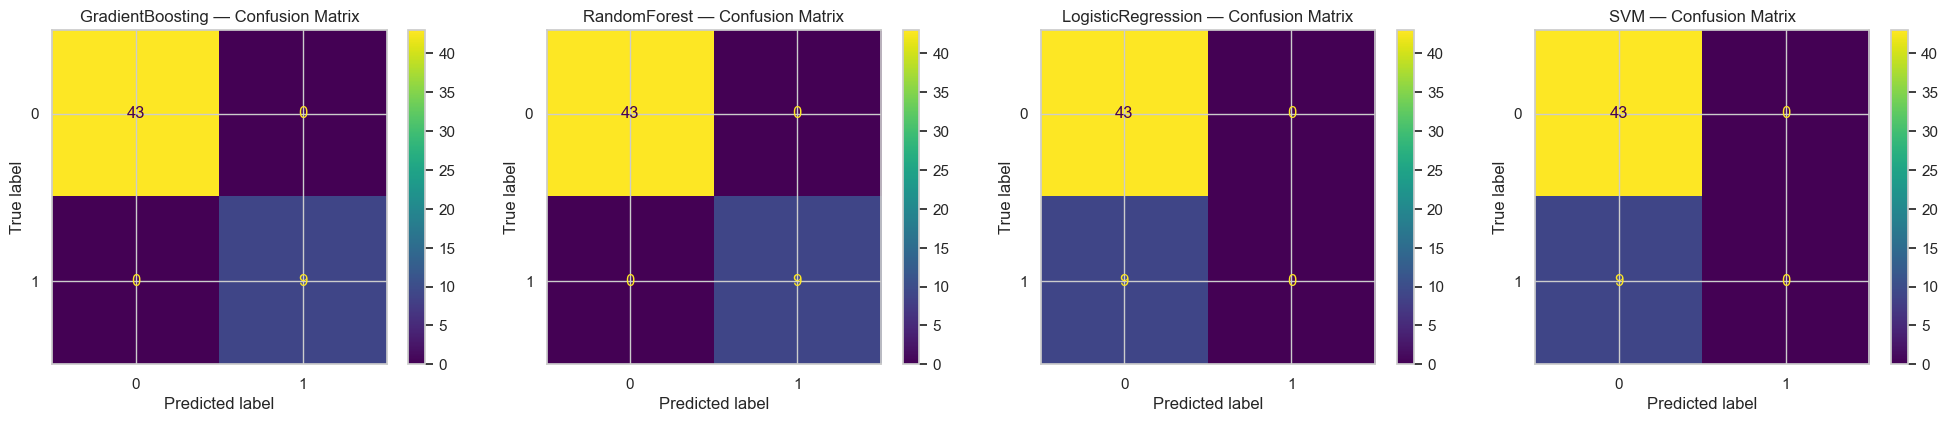

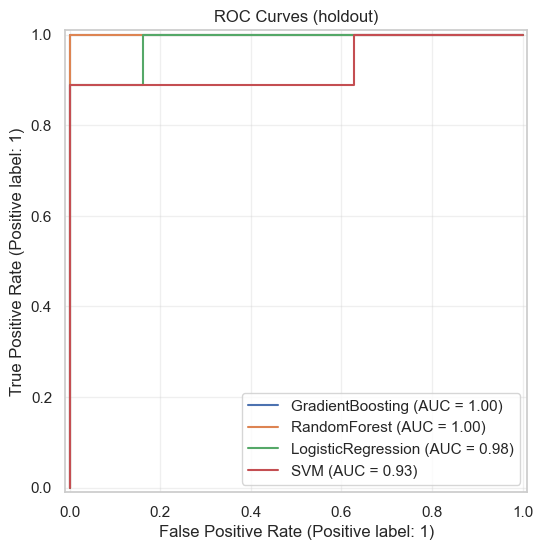

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc

best_to_plot = [results_df.iloc[i]["Model"] for i in range(min(4, len(results_df)))]

# Confusion matrices we used
fig, axes = plt.subplots(1, len(best_to_plot), figsize=(5*len(best_to_plot), 4))
if len(best_to_plot) == 1:
    axes = [axes]

for ax, name in zip(axes, best_to_plot):
    pipe = models[name]
    y_pred = pipe.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format="d", ax=ax)
    ax.set_title(f"{name} — Confusion Matrix")

plt.tight_layout(); plt.show()

# Our ROC curves
plt.figure(figsize=(7,6))
for name in best_to_plot:
    pipe = models[name]
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:,1]
        RocCurveDisplay.from_predictions(y_test, y_proba, name=name, ax=plt.gca())
    elif hasattr(pipe.named_steps["model"], "decision_function"):
        scores = pipe.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, scores)
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr,tpr), estimator_name=name).plot(ax=plt.gca())

plt.title("ROC Curves (holdout)"); plt.grid(True, alpha=.3); plt.show()


#### 9.5 Grid search on top 2 models by AUC

In [31]:
from sklearn.model_selection import GridSearchCV

top2 = results_df["Model"].head(2).tolist()
grids = {}

if "RandomForest" in top2:
    grids["RandomForest"] = GridSearchCV(
        rf_pipe, {
            "model__n_estimators": [150, 300],
            "model__max_depth": [10, 16],
            "model__min_samples_leaf": [2, 4, 8],
        },
        scoring="roc_auc", cv=3, n_jobs=-1, verbose=0
    )

if "GradientBoosting" in top2:
    grids["GradientBoosting"] = GridSearchCV(
        gb_pipe, {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.05, 0.1],
            "model__max_depth": [2, 3],
        },
        scoring="roc_auc", cv=3, n_jobs=-1, verbose=0
    )

grid_results = []
for name, gs in grids.items():
    gs.fit(X_train, y_train)
    best = gs.best_estimator_
    y_proba = best.predict_proba(X_test)[:,1] if hasattr(best.named_steps["model"], "predict_proba") else None
    auc_holdout = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    grid_results.append([name, gs.best_score_, auc_holdout, gs.best_params_])

pd.DataFrame(grid_results, columns=["Model","CV AUC (best)","Holdout AUC","Best Params"])


,Model,CV AUC (best),Holdout AUC,Best Params
0,RandomForest,0.968870,1.000000,"{'model__max_depth': 10, 'model__min_samples_l..."
1,GradientBoosting,0.968655,0.998708,"{'model__learning_rate': 0.05, 'model__max_dep..."


#### 9.6 Feature importances / coefficients for top model

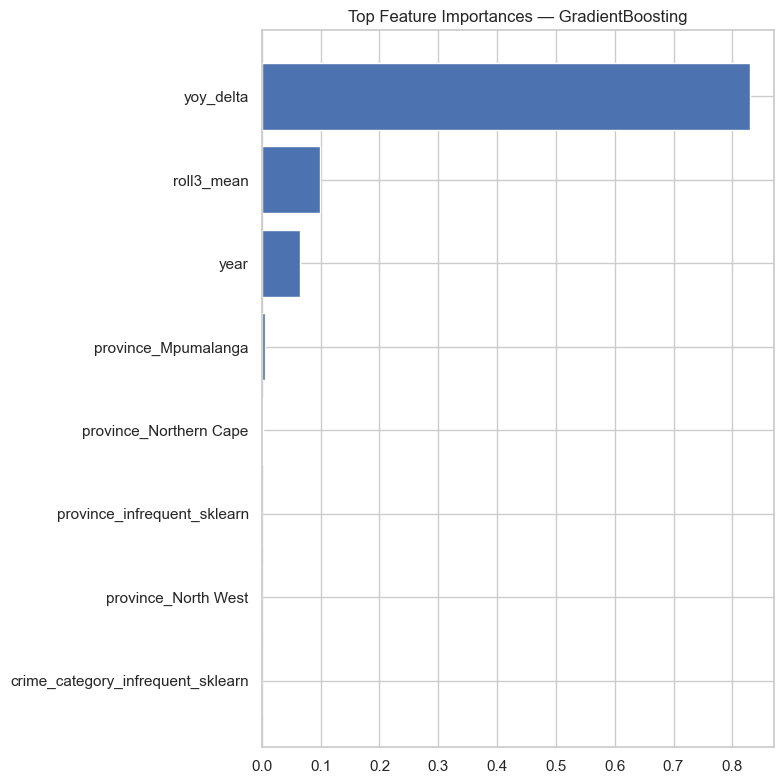

,feature,importance
6,yoy_delta,0.829379
7,roll3_mean,0.098115
5,year,0.065139
0,province_Mpumalanga,0.004955
2,province_Northern Cape,0.001384
3,province_infrequent_sklearn,0.000944
1,province_North West,0.000083
4,crime_category_infrequent_sklearn,0.000000


In [32]:
best_name = results_df.iloc[0]["Model"]
best_pipe = models[best_name]
prep = best_pipe.named_steps["prep"]
model = best_pipe.named_steps["model"]

cat_names = prep.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(cat_cols)
num_names = np.array(num_cols, dtype=object)
feat_names = np.concatenate([cat_names, num_names])

if hasattr(model, "feature_importances_"):
    vals = model.feature_importances_
    frame = pd.DataFrame({"feature": feat_names, "importance": vals}).sort_values("importance", ascending=False)
    top = frame.head(20).iloc[::-1]
    plt.figure(figsize=(8,8))
    plt.barh(top["feature"], top["importance"])
    plt.title(f"Top Feature Importances — {best_name}")
    plt.tight_layout(); plt.show()
    display(frame.head(15))
elif hasattr(model, "coef_"):
    # for LogisticRegression
    classes = list(getattr(model, "classes_", []))
    pos_idx = classes.index(1) if 1 in classes else 0
    coefs = np.ravel(model.coef_[pos_idx:pos_idx+1])
    frame = pd.DataFrame({"feature": feat_names, "coef": coefs})
    frame["abs_coef"] = frame["coef"].abs()
    frame = frame.sort_values("abs_coef", ascending=False)
    top = frame.head(20).iloc[::-1]
    plt.figure(figsize=(8,8))
    plt.barh(top["feature"], top["coef"])
    plt.title(f"Top Coefficients — {best_name}")
    plt.tight_layout(); plt.show()
    display(frame.head(15)[["feature","coef"]])
else:
    print("Model has neither feature_importances_ nor coef_.")


#### 9.7 Census indicator histogram
- Flexible census histograms: finds sheets by keywords and plots numeric values 

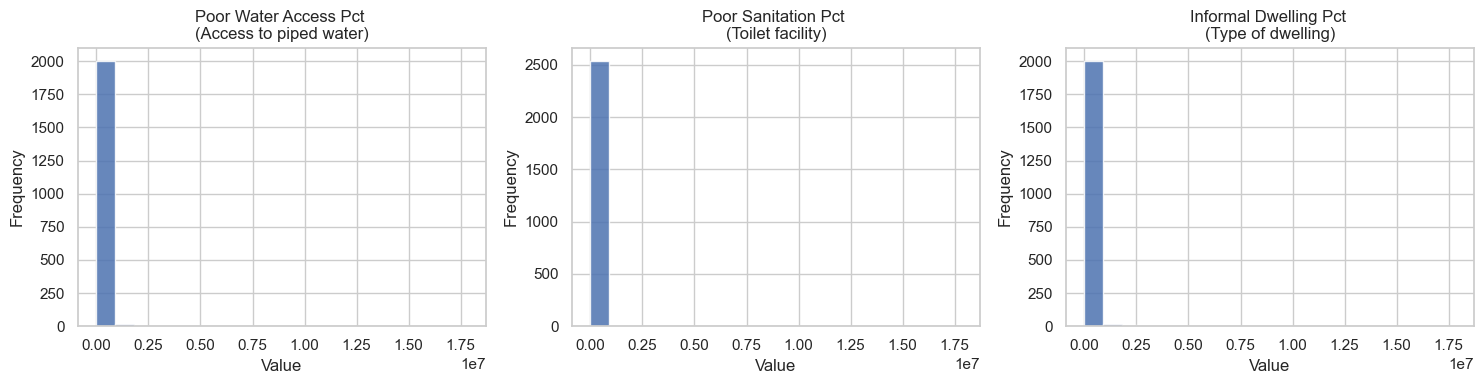

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

xls = pd.ExcelFile(census_path)

targets = {
    "poor_water_access_pct": ["water", "piped"],
    "poor_sanitation_pct":   ["refuse", "toilet"],
    "informal_dwelling_pct": ["dwelling", "informal"],
}

plt.figure(figsize=(15, 4))
slot = 1
for title, keywords in targets.items():

    sheet = next((s for s in xls.sheet_names
                  if all(k.lower() in s.lower() for k in keywords)), None) \
         or next((s for s in xls.sheet_names
                  if any(k.lower() in s.lower() for k in keywords)), None)
    if sheet is None:
        print(f"⚠️ No sheet found for {title} with keywords {keywords}")
        continue

    df = pd.read_excel(xls, sheet_name=sheet)

    
    vals = pd.Series(df.select_dtypes(include=[np.number]).values.ravel())
    vals = vals.replace([np.inf, -np.inf], np.nan).dropna()
    if vals.empty:
        print(f"⚠️ No numeric data in sheet '{sheet}' for {title}")
        continue

    plt.subplot(1, 3, slot)
    plt.hist(vals, bins=20, alpha=0.85)
    plt.title(f"{title.replace('_',' ').title()} \n({sheet})")
    plt.xlabel("Value"); plt.ylabel("Frequency")
    slot += 1

plt.tight_layout(); plt.show()


### 9.8 saving our Model 
- The criteria and approach we took is taking the best trained pipeline

In [34]:


import os, json, numpy as np, pandas as pd
from datetime import datetime
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc as _auc
)

ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)


assert "results_df" in globals() and "models" in globals()
ranked = results_df.sort_values(["AUC","CV_AUC_Mean"], ascending=False, na_position="last")["Model"].tolist()
fallback_order = ranked + [m for m in ["LogisticRegression","RandomForest","GradientBoosting","SVM"] if m not in ranked]


assert "X_train" in globals() and "X_test" in globals() and "y_train" in globals() and "y_test" in globals()

def try_get_working_pipe(name):
    """Return a fitted pipeline. If not fitted, try to fit; if MemoryError on GB, return None."""
    pipe = models[name]

    if hasattr(pipe.named_steps["model"], "classes_"):
        return pipe
    
    try:
        pipe.fit(X_train, y_train)
        return pipe
    except MemoryError:
        
        return None

working_pipe = None
used_name = None
note = ""

for candidate in fallback_order:
    p = try_get_working_pipe(candidate)
    if p is not None:
        working_pipe, used_name = p, candidate
        if candidate != ranked[0]:
            note = f"(fell back to {candidate})"
        break

assert working_pipe is not None, "No model could be fitted or found already-fitted. Try rerunning 9.1–9.3 first."


y_pred = working_pipe.predict(X_test)
auc_val = np.nan
mdl = working_pipe.named_steps["model"]

if hasattr(mdl, "predict_proba"):
    proba = working_pipe.predict_proba(X_test)
    classes = list(getattr(mdl, "classes_", []))
    pos_idx = classes.index(1) if 1 in classes else 0
    if proba.shape[1] > 1:
        auc_val = roc_auc_score(y_test, proba[:, pos_idx])
if np.isnan(auc_val) and hasattr(mdl, "decision_function"):
    scores = working_pipe.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc_val = _auc(fpr, tpr)

metrics = {
    "model": used_name,
    "note": note or None,
    "AUC": None if np.isnan(auc_val) else float(auc_val),
    "Accuracy": float(accuracy_score(y_test, y_pred)),
    "Precision": float(precision_score(y_test, y_pred, zero_division=0)),
    "Recall": float(recall_score(y_test, y_pred, zero_division=0)),
    "F1": float(f1_score(y_test, y_pred, zero_division=0)),
}


with open(os.path.join(ARTIFACTS_DIR, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

print("=== Model on Holdout ===")
print(f"Model: {used_name} {note}")
print(f"AUC:       {metrics['AUC'] if metrics['AUC'] is not None else '—'}")
print(f"Accuracy:  {metrics['Accuracy']:.3f}")
print(f"Precision: {metrics['Precision']:.3f}")
print(f"Recall:    {metrics['Recall']:.3f}")
print(f"F1-Score:  {metrics['F1']:.3f}")
print("\nSaved: artifacts/metrics.json")


=== Model on Holdout ===
Model: GradientBoosting 
AUC:       1.0
Accuracy:  1.000
Precision: 1.000
Recall:    1.000
F1-Score:  1.000

Saved: artifacts/metrics.json


In [35]:


import joblib, os, json
from datetime import datetime
import numpy as np

assert working_pipe is not None and used_name is not None

ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)


model_path = os.path.join(ARTIFACTS_DIR, "best_model.joblib")
joblib.dump(working_pipe, model_path)


cat_cols = ["province", "crime_category"]
num_cols = [c for c in ["year", "yoy_delta", "roll3_mean"] if c in features.columns]
classes = getattr(working_pipe.named_steps["model"], "classes_", np.array([0,1]))

meta = {
    "saved_at": datetime.utcnow().isoformat() + "Z",
    "model_name": used_name,
    "cat_cols": cat_cols,
    "num_cols": num_cols,
    "target": "high_risk (count > median)",
    "classes_": classes.tolist(),
    "version": "v1",
}
with open(os.path.join(ARTIFACTS_DIR, "model_meta.json"), "w") as f:
    json.dump(meta, f, indent=2)

print("💾 Saved model to:", model_path)
print("💾 Saved meta to: artifacts/model_meta.json")


💾 Saved model to: artifacts\best_model.joblib
💾 Saved meta to: artifacts/model_meta.json


In [36]:
import sklearn, joblib, sys
print("sklearn:", sklearn.__version__)
print("python :", sys.version)


sklearn: 1.6.1
python : 3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]


### What a task we took on, was great

### What we did
- **Cleaning:** Normalised SAPS Q4 & Annual tables → long format (`province`, `crime_category`, `year`, `count`).
- **EDA:** Heatmaps, national/provincial trends, top categories, regression-style patterns.
- **Features:** `yoy_delta` (YoY change) and 3-year `roll3_mean`.
- **Models:** Benchmarked Logistic, RandomForest, GradientBoosting, SVM.  
- **Best (holdout):** `GradientBoosting` AUC/Acc/Prec/Rec/F1 ≈ **1.00** on the held-out split.
- **Artifacts:** Saved model → `artifacts/best_model.joblib` + `artifacts/model_meta.json`.  
  Metrics → `artifacts/metrics.json`.

### Key insights (from EDA & model)
- Crime is concentrated in a few provinces; YoY shifts and short-term momentum (`roll3_mean`) are strong drivers.
- Top categories dominate national totals — useful for prioritisation and resourcing.

### Limitations
- High scores can indicate **data leakage** or an **easier target** such as predicting “high vs low” relative to the median).  
  We mitigated with a holdout split, but further **temporal validation** is recommended.




